In [1]:
from helita.sim import bifrost as br

In [2]:
dd = br.BifrostData('cb10f', snap = 430, fdir = '/net/opal/Volumes/Amnesia/mpi3drun/Granflux', verbose = False)

In [3]:
var1 = dd.get_var('r', snap = 430, iiy = 200, iiz = [5, 7])

In [4]:
time = dd.params['t']

In [5]:
dd.params.keys()

dict_keys(['mx', 'my', 'mz', 'mb', 'nstep', 'nstepstart', 'debug', 'periodic_x', 'periodic_y', 'periodic_z', 'ndim', 'u_l', 'u_t', 'u_r', 'u_p', 'u_u', 'u_kr', 'u_ee', 'u_e', 'u_te', 'u_tg', 'u_b', 'meshfile', 'dx', 'dy', 'dz', 'cdt', 'dt', 't', 'timestepdebug', 'nu1', 'nu2', 'nu3', 'nu_r_xy', 'nu_r_xy_k', 'nu_r', 'nu_r_min', 'nu_r_k', 'nu_ee_xy', 'nu_ee', 'grav', 'eta3', 'ca_max', 'mhddebug', 'do_mhd', 'mhdclean', 'one_file', 'snapname', 'isnap', 'large_memory', 'nsnap', 'nscr', 'aux', 'dtsnap', 'newaux', 'dtscr', 'tsnap', 'tscr', 'boundarychk', 'max_r', 'smooth_r', 'qmax', 'noneq', 'do_hion', 'gamma', 'tabinputfile', 'do_rad', 'dtrad', 'quadrature', 'zrefine', 'maxiter', 'taustream', 'accuracy', 'strictint', 'linear', 'monotonic', 'minbin', 'maxbin', 'dualsweep', 'teff', 'timing', 'spitzer', 'debug_spitzer', 'info_spitzer', 'spitzer_amp', 'theta_mg', 'dtgerr', 'ntest_mg', 'tgb0', 'tgb1', 'tau_tg', 'fix_grad_tg', 'niter_mg', 'bmin', 'do_genrad', 'genradfile', 'debug_genrad', 'incrad_d

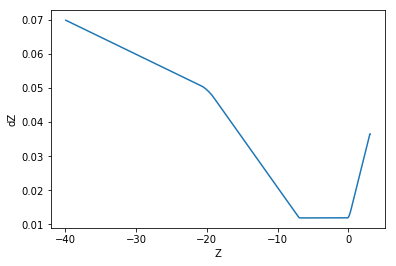

In [6]:
from helita.sim import bifrost as br
import matplotlib.pyplot as plt
import numpy as np

rootname='l2d90x40r_it' #this is for the 2D case
fdir='/net/opal/Volumes/Amnesia/mpi3drun/2Druns/genohm/rain/l2d90x40r'
dd=br.BifrostData(rootname,fdir=fdir, verbose = False) #this loads the structure
var=dd.get_var('r',305) #this reads the density (r) for the instant 305 

# gets the z coordinates of data points and makes an empty array of the same length for values of dz
zArr = dd.z
length = zArr.shape[0]
dzArr = np.empty([length])

# iterates through zArr and sets each entry in dzArr as the difference between the next and current values of z
# for the final value of dzArr, sets it to be the same as the previous value of dzArr
for i, val in enumerate(zArr):
    if i < length - 1 :
        dzArr[i] = zArr[i + 1] - val
        i = i + 1
        
    else :
        dzArr[i] = dzArr[i - 1]

# plots z vs dz and labels the axes
plt.plot(zArr, dzArr)
plt.xlabel('Z')
plt.ylabel('dZ')
plt.show()



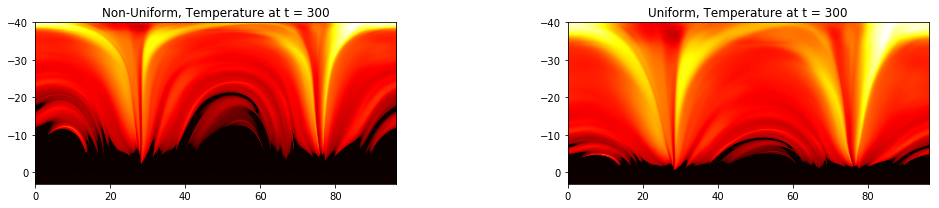

In [7]:
import scipy.interpolate as sp
import pylab
# bifrost already imported and dd initialized after previous example

def graphTemp(time):
    temp = dd.get_var('tg', time)

    zArr = dd.z
    xArr = dd.x

    # at instant 305 -  x is uniform, y is kept constant, and z is non uniform
    
    # converts the 3d array with width of 1 to 2d array (and transposes because otherwise image is sidewise)
    temp2D = np.transpose(temp[:,0])

    f = sp.interp2d(xArr, zArr, temp2D)

    # makes a new uniform z, x is already uniform
    zLength = zArr.shape[0]
    zStart = zArr[0]
    zEnd = zArr[zLength - 1]
    newZ = np.linspace(zStart, zEnd, zLength)

    # makes the interpolated data with the previously created interpolation function acting on the new uniform axes
    uniA = f(xArr, newZ)
    
    fig = plt.figure(figsize = (15, 3))
    
    # optional plotting of the non uniform data to show the difference
    ax0 = fig.add_subplot(1, 2, 1)
    ax0.imshow(temp2D, cmap = 'hot', extent = (xArr[0], xArr[xArr.shape[0] - 1], zEnd, zStart), aspect = 'equal')
    ax0.set_title('Non-Uniform, Temperature at t = ' + str(time))
    
    ax1 = fig.add_subplot(1, 2, 2)
    ax1.imshow(uniA, cmap = 'hot', extent = (xArr[0], xArr[xArr.shape[0] - 1], zEnd, zStart), aspect = 'equal')
    ax1.set_title('Uniform, Temperature at t = ' + str(time))
    plt.tight_layout()
    plt.show()
    
graphTemp(300)

In [8]:
from helita.sim import bifrost_fft as brft

In [9]:
dd = brft.FFTData(file_root = 'cb10f', fdir = '/net/opal/Volumes/Amnesia/mpi3drun/Granflux')

In [10]:
transformed = dd.get_fft('r', snap = [430, 431, 432], iiy = 20)

In [11]:
transformed.keys()

dict_keys(['freq', 'ftCube'])

In [12]:
dd.run_gpu() # to use GPU
dd.run_gpu(False) # to stop use of GPU

In [13]:
usingBlocks = dd.get_fft('bx', snap = [400, 401, 402], numBlocks = 5)

In [14]:
usingThreads = dd.get_fft('bx', snap = [400, 401, 402], numThreads = 10)